In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("hugomathien/soccer")

# print("Path to dataset files:", path)

In [2]:
import sqlite3
import pandas as pd

# Path to your SQLite database file
db_path = 'database.sqlite'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Function to load a table into a DataFrame
def load_table(table_name):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    print(f"Loaded '{table_name}' with shape {df.shape}")
    return df

# Load tables
player_df = load_table('Player')
player_attributes_df = load_table('Player_Attributes')
team_df = load_table('Team')
team_attributes_df = load_table('Team_Attributes')
match_df = load_table('Match')
league_df = load_table('League')
country_df = load_table('Country')

# Close the connection
conn.close()


Loaded 'Player' with shape (11060, 7)
Loaded 'Player_Attributes' with shape (183978, 42)
Loaded 'Team' with shape (299, 5)
Loaded 'Team_Attributes' with shape (1458, 25)
Loaded 'Match' with shape (25979, 115)
Loaded 'League' with shape (11, 3)
Loaded 'Country' with shape (11, 2)


In [3]:
print("Player DataFrame:")
print(player_df.head())

print("\nPlayer Attributes DataFrame:")
print(player_attributes_df.head())

print("\nTeam DataFrame:")
print(team_df.head())

print("\nTeam Attributes DataFrame:")
print(team_attributes_df.head())

print("\nMatch DataFrame:")
print(match_df.head())

print("\nLeague DataFrame:")
print(league_df.head())

print("\nCountry DataFrame:")
print(country_df.head())


Player DataFrame:
   id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154  

Player Attributes DataFrame:
   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0 

In [4]:
# Select relevant columns from Match DataFrame
match_cols = [
    'id', 'country_id', 'league_id', 'season', 'stage', 'date', 
    'match_api_id', 'home_team_api_id', 'away_team_api_id', 
    'home_team_goal', 'away_team_goal',
    # Betting odds columns can be added here if needed
]

matches = match_df[match_cols]
matches['date'] = pd.to_datetime(matches['date'])
print(matches.head())


print(f"Total matches: {len(matches)}")
print(f"Unique match IDs: {matches['id'].nunique()}")

# Check for missing or duplicated IDs
print(f"Missing IDs: {matches['id'].isnull().sum()}")
print(f"Duplicated IDs: {matches['id'].duplicated().sum()}")


   id  country_id  league_id     season  stage       date  match_api_id  \
0   1           1          1  2008/2009      1 2008-08-17        492473   
1   2           1          1  2008/2009      1 2008-08-16        492474   
2   3           1          1  2008/2009      1 2008-08-16        492475   
3   4           1          1  2008/2009      1 2008-08-17        492476   
4   5           1          1  2008/2009      1 2008-08-16        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  
0              9987              9993               1               1  
1             10000              9994               0               0  
2              9984              8635               0               3  
3              9991              9998               5               0  
4              7947              9985               1               3  
Total matches: 25979
Unique match IDs: 25979
Missing IDs: 0
Duplicated IDs: 0


/var/folders/s5/1s5n05k56ds1wdhfq1bd19zc0000gn/T/ipykernel_59283/198944640.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['date'] = pd.to_datetime(matches['date'])


In [5]:
# Rename 'id' in 'matches' to 'match_id' to prevent overwriting during merges
matches.rename(columns={'id': 'match_id'}, inplace=True)

# Join matches with country_df
matches = matches.merge(
    country_df[['id', 'name']],
    left_on='country_id',
    right_on='id',
    how='left',
    suffixes=('', '_country')
)
matches.rename(columns={'name': 'country_name'}, inplace=True)
# Drop the redundant 'id_country' column
matches.drop(columns=['country_id'], inplace=True)

# Join matches with league_df
matches = matches.merge(
    league_df[['id', 'name']],
    left_on='league_id',
    right_on='id',
    how='left',
    suffixes=('', '_league')
)
matches.rename(columns={'name': 'league_name'}, inplace=True)
# Drop the redundant 'id_league' column
matches.drop(columns=['id_league'], inplace=True)

# Ensure team_df has unique team_api_id entries
team_unique_df = team_df.drop_duplicates(subset=['team_api_id'])

# Join matches with team_df for Home Team Names
matches = matches.merge(
    team_unique_df[['team_api_id', 'team_long_name']],
    left_on='home_team_api_id',
    right_on='team_api_id',
    how='left'
)
matches.rename(columns={'team_long_name': 'home_team_name'}, inplace=True)
# Drop redundant columns after home team merge
matches.drop(columns=['team_api_id'], inplace=True)

# Join matches with team_df for Away Team Names
matches = matches.merge(
    team_unique_df[['team_api_id', 'team_long_name']],
    left_on='away_team_api_id',
    right_on='team_api_id',
    how='left',
    suffixes=('', '_away')
)
matches.rename(columns={'team_long_name': 'away_team_name'}, inplace=True)
# Drop redundant columns after away team merge
matches.drop(columns=['team_api_id'], inplace=True)

# Verify the updated DataFrame
print(matches[['match_id', 'country_name', 'league_name', 'home_team_name', 'away_team_name', 'date', 'season', 'home_team_goal', 'away_team_goal']].head())

# Check for duplicates
print(f"Total matches: {len(matches)}")
print(f"Unique match IDs: {matches['match_id'].nunique()}")
print(f"Missing IDs: {matches['match_id'].isnull().sum()}")
print(f"Duplicated IDs: {matches['match_id'].duplicated().sum()}")


   match_id country_name             league_name     home_team_name  \
0         1      Belgium  Belgium Jupiler League           KRC Genk   
1         2      Belgium  Belgium Jupiler League   SV Zulte-Waregem   
2         3      Belgium  Belgium Jupiler League  KSV Cercle Brugge   
3         4      Belgium  Belgium Jupiler League           KAA Gent   
4         5      Belgium  Belgium Jupiler League      FCV Dender EH   

      away_team_name       date     season  home_team_goal  away_team_goal  
0       Beerschot AC 2008-08-17  2008/2009               1               1  
1   Sporting Lokeren 2008-08-16  2008/2009               0               0  
2     RSC Anderlecht 2008-08-16  2008/2009               0               3  
3          RAEC Mons 2008-08-17  2008/2009               5               0  
4  Standard de Liège 2008-08-16  2008/2009               1               3  
Total matches: 25979
Unique match IDs: 25979
Missing IDs: 0
Duplicated IDs: 0


/var/folders/s5/1s5n05k56ds1wdhfq1bd19zc0000gn/T/ipykernel_59283/3982648545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches.rename(columns={'id': 'match_id'}, inplace=True)


In [6]:
# # Join Match table with Country table
# matches = matches.merge(country_df, left_on='country_id', right_on='id', how='left')
# matches.rename(columns={'name': 'country_name'}, inplace=True)

# # Join Match table with League table
# matches = matches.merge(league_df, left_on='league_id', right_on='id', how='left')
# matches.rename(columns={'name': 'league_name'}, inplace=True)

# # Join Match table with Team table for Home Team Names
# matches = matches.merge(
#     team_df[['team_api_id', 'team_long_name']],
#     left_on='home_team_api_id',
#     right_on='team_api_id',
#     how='left'
# )
# matches.rename(columns={'team_long_name': 'home_team_name'}, inplace=True)

# # Drop redundant columns after home team merge
# matches.drop(columns=['team_api_id'], inplace=True, errors='ignore')

# # Join Match table with Team table for Away Team Names
# matches = matches.merge(
#     team_df[['team_api_id', 'team_long_name']],
#     left_on='away_team_api_id',
#     right_on='team_api_id',
#     how='left'
# )
# matches.rename(columns={'team_long_name': 'away_team_name'}, inplace=True)

# # Drop redundant columns after away team merge
# matches.drop(columns=['team_api_id'], inplace=True, errors='ignore')

# # Verify the updated DataFrame
# print(matches[['country_name', 'league_name', 'home_team_name', 'away_team_name', 'date', 'season', 'home_team_goal', 'away_team_goal']].head())

In [7]:
# Create a graph
import networkx as nx

G = nx.Graph()

# Add matches as nodes
for match_id, home_team, away_team in zip(matches['match_id'], matches['home_team_name'], matches['away_team_name']):
    G.add_node(match_id, home_team=home_team, away_team=away_team)

# Number of nodes
num_nodes = G.number_of_nodes()
print(f"Number of nodes: {num_nodes}")


Number of nodes: 25979


In [8]:
# Check the number of unique match IDs
print(f"Total matches: {len(matches)}")
print(f"Unique match IDs: {matches['match_id'].nunique()}")

# Check for missing or duplicated IDs
print(f"Missing IDs: {matches['match_id'].isnull().sum()}")
print(f"Duplicated IDs: {matches['match_id'].duplicated().sum()}")


Total matches: 25979
Unique match IDs: 25979
Missing IDs: 0
Duplicated IDs: 0


In [9]:
# Edge list with home and away teams
edges = matches[['home_team_name', 'away_team_name', 'season']].copy()
edges['weight'] = 1  # Initialize weight

# Optionally, include match outcomes or other attributes
edges['home_team_goals'] = matches['home_team_goal']
edges['away_team_goals'] = matches['away_team_goal']


In [10]:
# Group by team pairs and sum weights
edges_aggregated = edges.groupby(['home_team_name', 'away_team_name'], as_index=False).agg({
    'weight': 'sum',
    'home_team_goals': 'sum',
    'away_team_goals': 'sum'
})

print(edges_aggregated.head())


         home_team_name       away_team_name  weight  home_team_goals  \
0  1. FC Kaiserslautern           1. FC Köln       2                1   
1  1. FC Kaiserslautern       1. FC Nürnberg       2                0   
2  1. FC Kaiserslautern      1. FSV Mainz 05       2                3   
3  1. FC Kaiserslautern  Bayer 04 Leverkusen       2                0   
4  1. FC Kaiserslautern    Borussia Dortmund       2                3   

   away_team_goals  
0                2  
1                4  
2                2  
3                3  
4                6  


In [11]:
import networkx as nx

# Create a directed graph (since home and away teams are distinct)
G = nx.DiGraph()

# Add edges to the graph
for _, row in edges.iterrows():
    G.add_edge(
        row['home_team_name'],
        row['away_team_name'],
        weight=row['weight'],
        home_goals=row['home_team_goals'],
        away_goals=row['away_team_goals'],
        season=row['season']
    )

# Now G contains all your nodes and edges


Number of links: 6925


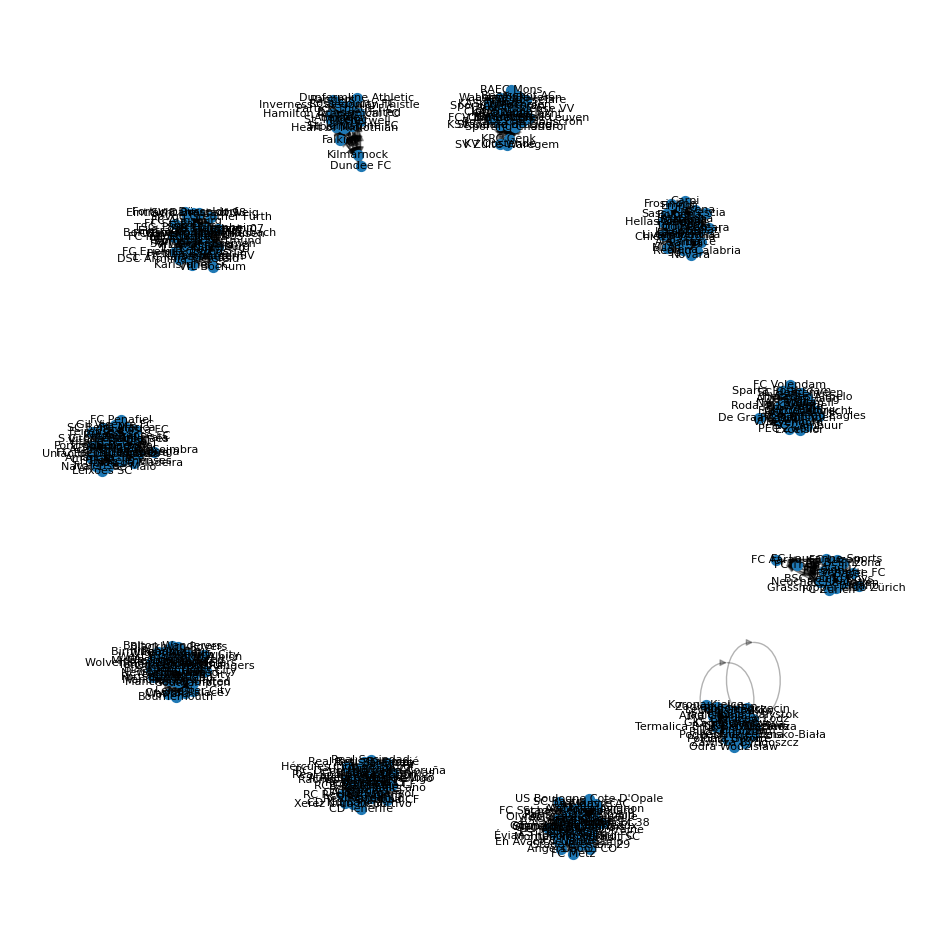

In [12]:
# Example: Draw the graph
import matplotlib.pyplot as plt

num_links = G.number_of_edges()
print(f"Number of links: {num_links}")

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)  # Positions for all nodes

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Optionally, add labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.show()


In [13]:
# Combine home and away team names to get all team names
all_teams = pd.concat([edges['home_team_name'], edges['away_team_name']])
unique_teams = all_teams.unique()

# Number of nodes
num_nodes = len(unique_teams)

print(f"Number of nodes (teams): {num_nodes}")


Number of nodes (teams): 296


In [ ]:
import numpy as np

# Create a new DataFrame with sorted team pairs to avoid duplicates
edges_undirected = edges.copy()
edges_undirected[['team1', 'team2']] = np.sort(edges[['home_team_name', 'away_team_name']], axis=1)
edges_undirected = edges_undirected.groupby(['team1', 'team2'], as_index=False).agg({'weight': 'sum'})

# Number of links
num_links = len(edges_undirected)

print(f"Number of links (matches between unique team pairs): {num_links}")


Number of links (matches between unique team pairs): 3465


In [15]:
# Create an undirected graph
G = nx.Graph()

# Add edges to the graph
for _, row in edges_undirected.iterrows():
    G.add_edge(row['team1'], row['team2'], weight=row['weight'])

# Compute degrees
degree_dict = dict(G.degree())
degree_df = pd.DataFrame(degree_dict.items(), columns=['team', 'degree'])

# Display degree distribution
print(degree_df.head())


                   team  degree
0  1. FC Kaiserslautern      19
1            1. FC Köln      26
2        1. FC Nürnberg      23
3       1. FSV Mainz 05      26
4   Bayer 04 Leverkusen      29


In [16]:
import numpy as np

degrees = np.array(list(degree_dict.values()))
min_degree = degrees.min()
max_degree = degrees.max()
average_degree = degrees.mean()

print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")
print(f"Average Degree: {average_degree:.2f}")


Minimum Degree: 9
Maximum Degree: 34
Average Degree: 23.41


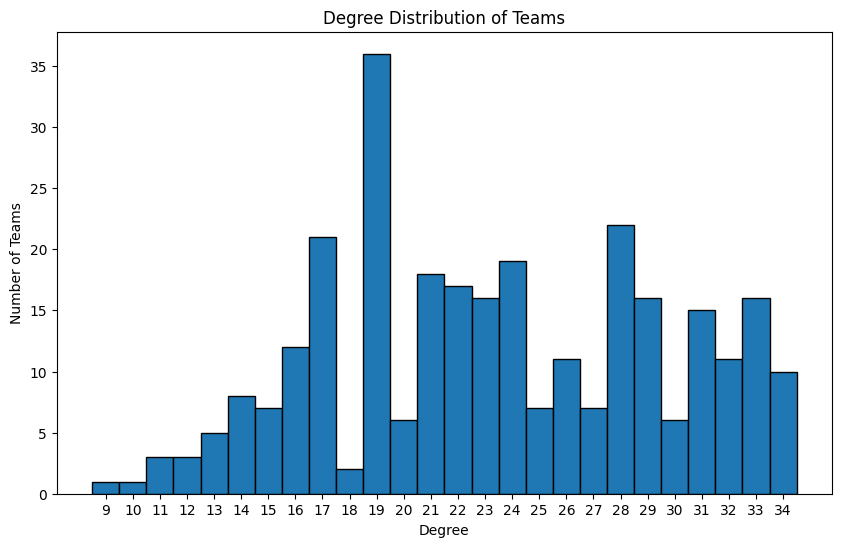

In [17]:
plt.figure(figsize=(10,6))
plt.hist(degrees, bins=range(min_degree, max_degree + 2), edgecolor='black', align='left')
plt.title('Degree Distribution of Teams')
plt.xlabel('Degree')
plt.ylabel('Number of Teams')
plt.xticks(range(min_degree, max_degree + 1))
plt.show()

In [18]:
# Total matches played by each team
matches_home = matches.groupby('home_team_name').size().reset_index(name='home_matches')
matches_away = matches.groupby('away_team_name').size().reset_index(name='away_matches')

# Merge home and away matches
total_matches = pd.merge(matches_home, matches_away, left_on='home_team_name', right_on='away_team_name', how='outer')
total_matches['team'] = total_matches['home_team_name'].combine_first(total_matches['away_team_name'])
total_matches['total_matches'] = total_matches['home_matches'].fillna(0) + total_matches['away_matches'].fillna(0)

# Total goals scored by each team
goals_scored_home = matches.groupby('home_team_name')['home_team_goal'].sum().reset_index(name='goals_scored_home')
goals_scored_away = matches.groupby('away_team_name')['away_team_goal'].sum().reset_index(name='goals_scored_away')

# Merge goals scored
total_goals_scored = pd.merge(goals_scored_home, goals_scored_away, left_on='home_team_name', right_on='away_team_name', how='outer')
total_goals_scored['team'] = total_goals_scored['home_team_name'].combine_first(total_goals_scored['away_team_name'])
total_goals_scored['total_goals_scored'] = total_goals_scored['goals_scored_home'].fillna(0) + total_goals_scored['goals_scored_away'].fillna(0)

# Merge matches and goals data
team_attributes = pd.merge(total_matches[['team', 'total_matches']], total_goals_scored[['team', 'total_goals_scored']], on='team')

# Add country and league information
team_info = matches[['home_team_name', 'country_name', 'league_name']].drop_duplicates()
team_info.rename(columns={'home_team_name': 'team'}, inplace=True)
team_attributes = pd.merge(team_attributes, team_info, on='team', how='left')

print(team_attributes.head())


                   team  total_matches  total_goals_scored country_name  \
0  1. FC Kaiserslautern             68                  72      Germany   
1            1. FC Köln            204                 226      Germany   
2        1. FC Nürnberg            170                 193      Germany   
3       1. FSV Mainz 05            238                 320      Germany   
4            AC Ajaccio            114                 116       France   

             league_name  
0  Germany 1. Bundesliga  
1  Germany 1. Bundesliga  
2  Germany 1. Bundesliga  
3  Germany 1. Bundesliga  
4         France Ligue 1  


In [19]:
# Add attributes to nodes in the graph
for _, row in team_attributes.iterrows():
    G.nodes[row['team']]['total_matches'] = row['total_matches']
    G.nodes[row['team']]['total_goals_scored'] = row['total_goals_scored']
    G.nodes[row['team']]['country'] = row['country_name']
    G.nodes[row['team']]['league'] = row['league_name']


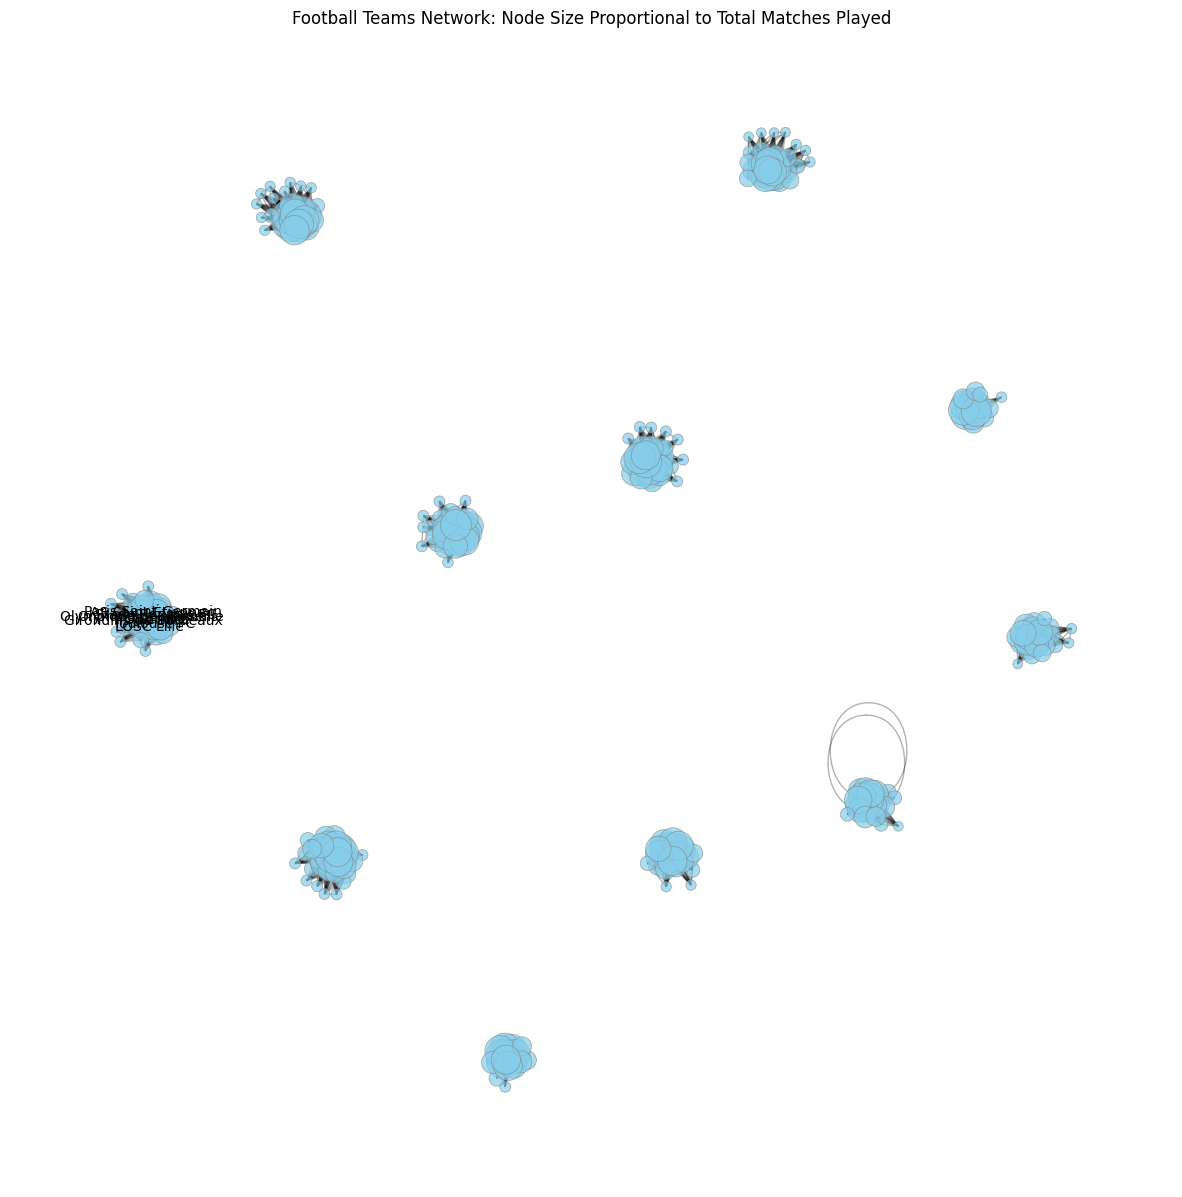

In [20]:

# Visualization 1: Node Size Proportional to Total Matches Played | Define node sizes based on total matches played
node_sizes = []
for node in G.nodes():
    total_matches = G.nodes[node].get('total_matches', 1)
    node_sizes.append(total_matches)

# Normalize node sizes for visualization purposes
max_size = max(node_sizes)
node_sizes = [500 * (size / max_size) for size in node_sizes]  # Scale sizes

# Draw the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15, seed=42)  # Positions for all nodes

# Draw nodes with sizes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7, linewidths=0.5, edgecolors='gray')

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Optionally, add labels for top teams
top_teams = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
top_team_names = [team for team, degree in top_teams]
labels = {team: team for team in top_team_names}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

plt.title('Football Teams Network: Node Size Proportional to Total Matches Played')
plt.axis('off')
plt.show()

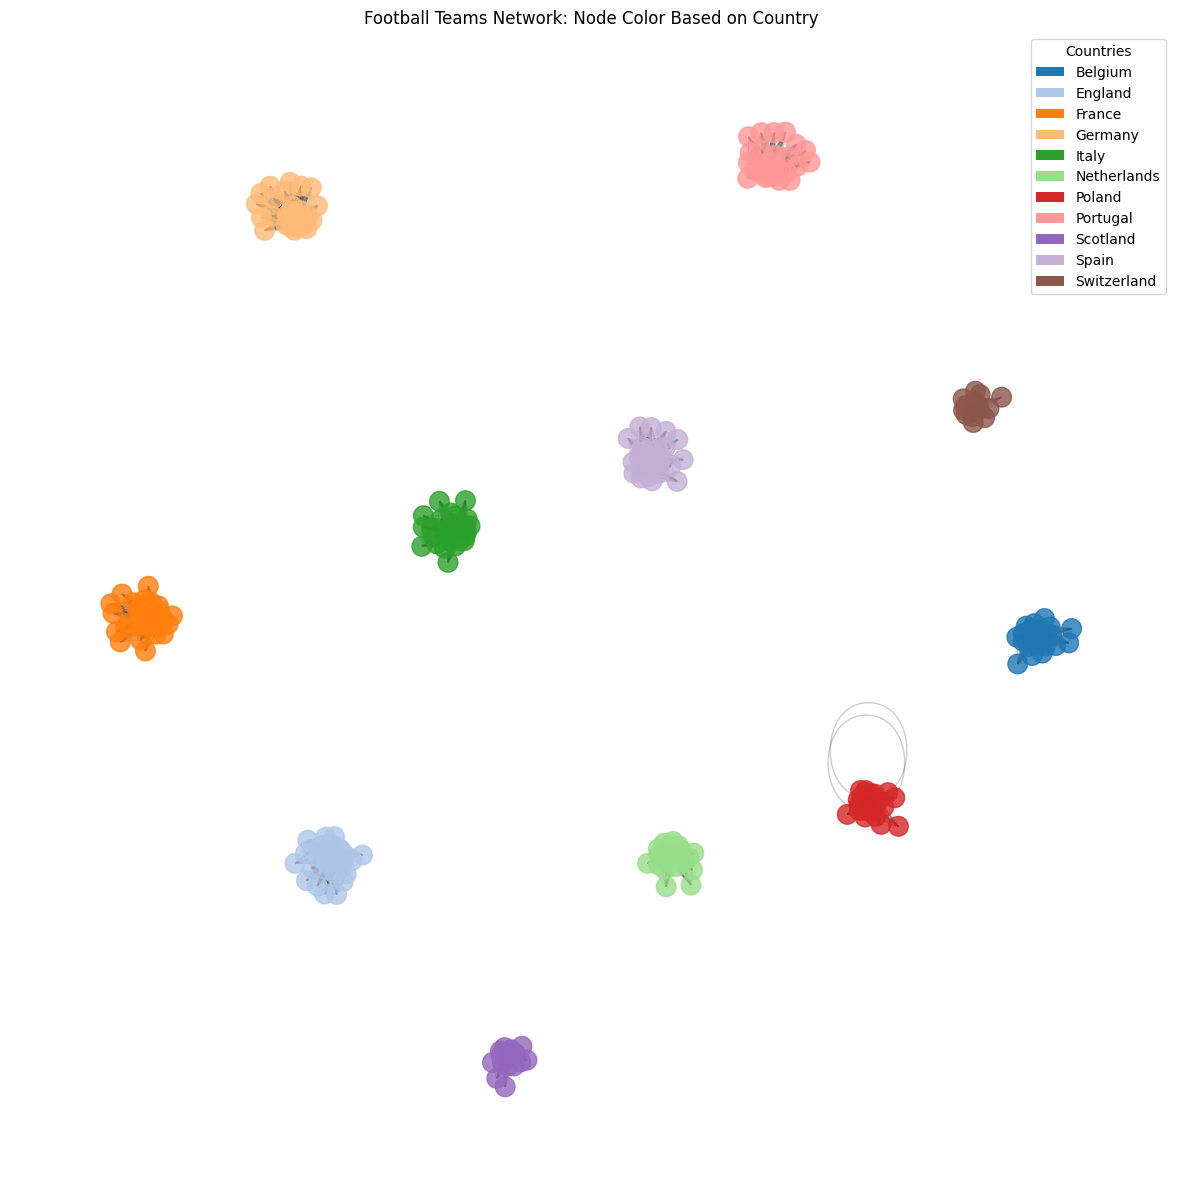

In [21]:
# Visualization 2: Node Color Based on Country |Get a list of countries
countries = list(set(nx.get_node_attributes(G, 'country').values()))
countries.sort()

# Create a color map
import matplotlib.colors as mcolors
color_list = list(mcolors.TABLEAU_COLORS.values())
if len(countries) > len(color_list):
    color_list = plt.cm.tab20.colors  # Use a colormap with more colors

country_color_map = {country: color_list[i % len(color_list)] for i, country in enumerate(countries)}

# Assign colors to nodes based on country
node_colors = []
for node in G.nodes():
    country = G.nodes[node].get('country', 'Unknown')
    node_colors.append(country_color_map.get(country, 'grey'))

# Draw the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw nodes with colors
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=node_colors, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Create a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=country) for country, color in country_color_map.items()]
plt.legend(handles=legend_elements, title='Countries', loc='best')

plt.title('Football Teams Network: Node Color Based on Country')
plt.axis('off')
plt.show()


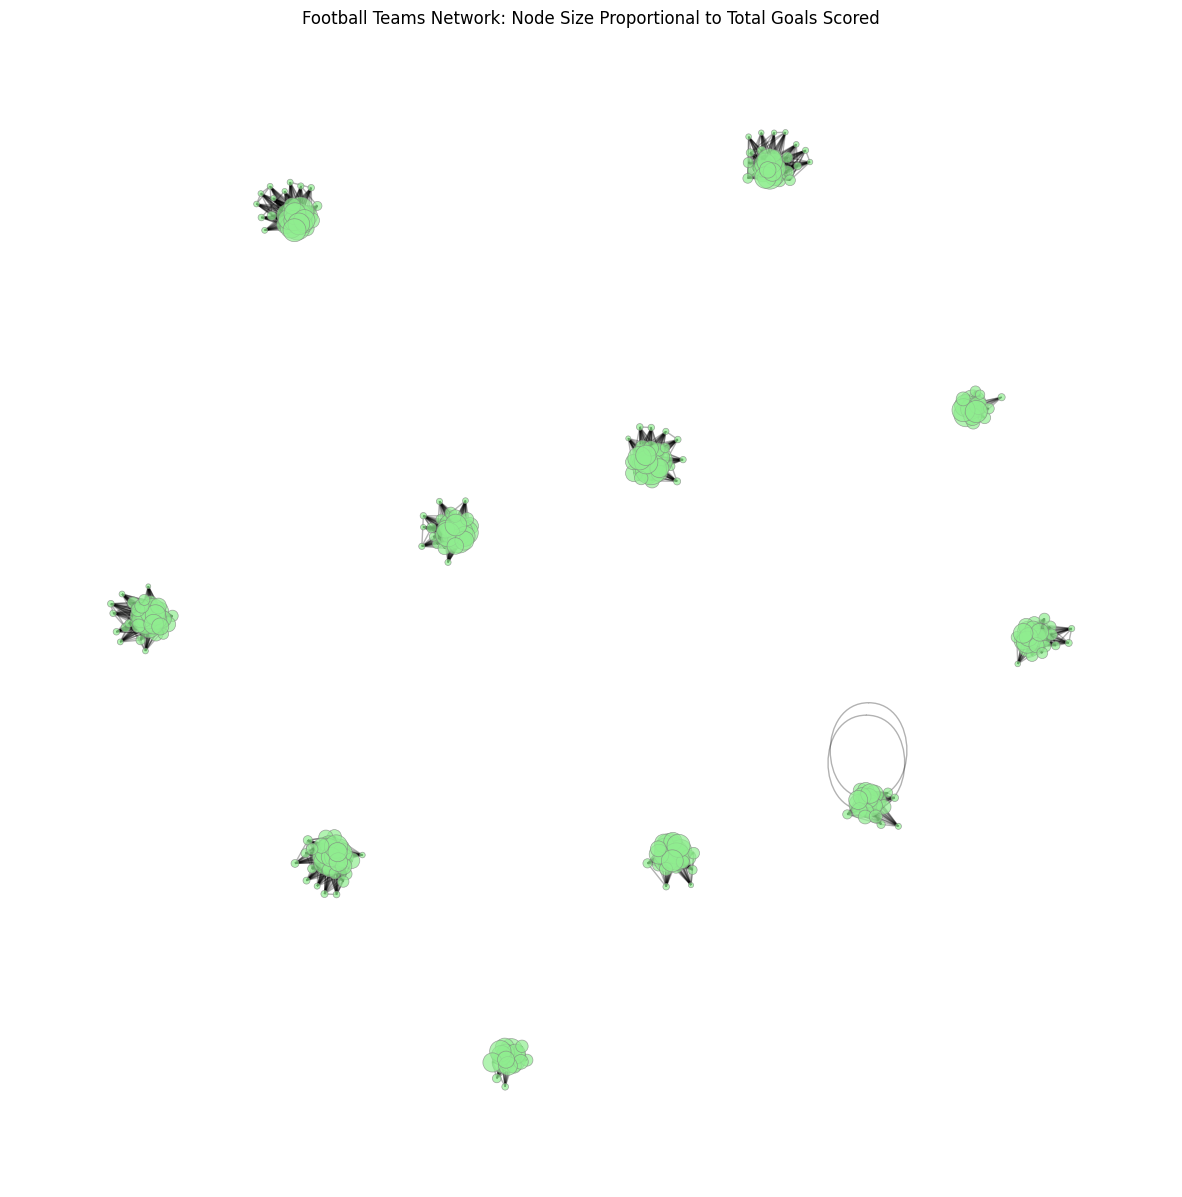

In [22]:
# Visualization 3: Node Size Based on Total Goals Scored | Define node sizes based on total goals scored
node_sizes_goals = []
for node in G.nodes():
    total_goals = G.nodes[node].get('total_goals_scored', 1)
    node_sizes_goals.append(total_goals)

# Normalize node sizes for visualization
max_goals = max(node_sizes_goals)
node_sizes_goals = [500 * (size / max_goals) for size in node_sizes_goals]

# Draw the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw nodes with sizes based on goals
nx.draw_networkx_nodes(G, pos, node_size=node_sizes_goals, node_color='lightgreen', alpha=0.7, linewidths=0.5, edgecolors='gray')

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title('Football Teams Network: Node Size Proportional to Total Goals Scored')
plt.axis('off')
plt.show()


/Users/hamzamajidqureshi/Desktop/Project Assignment/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

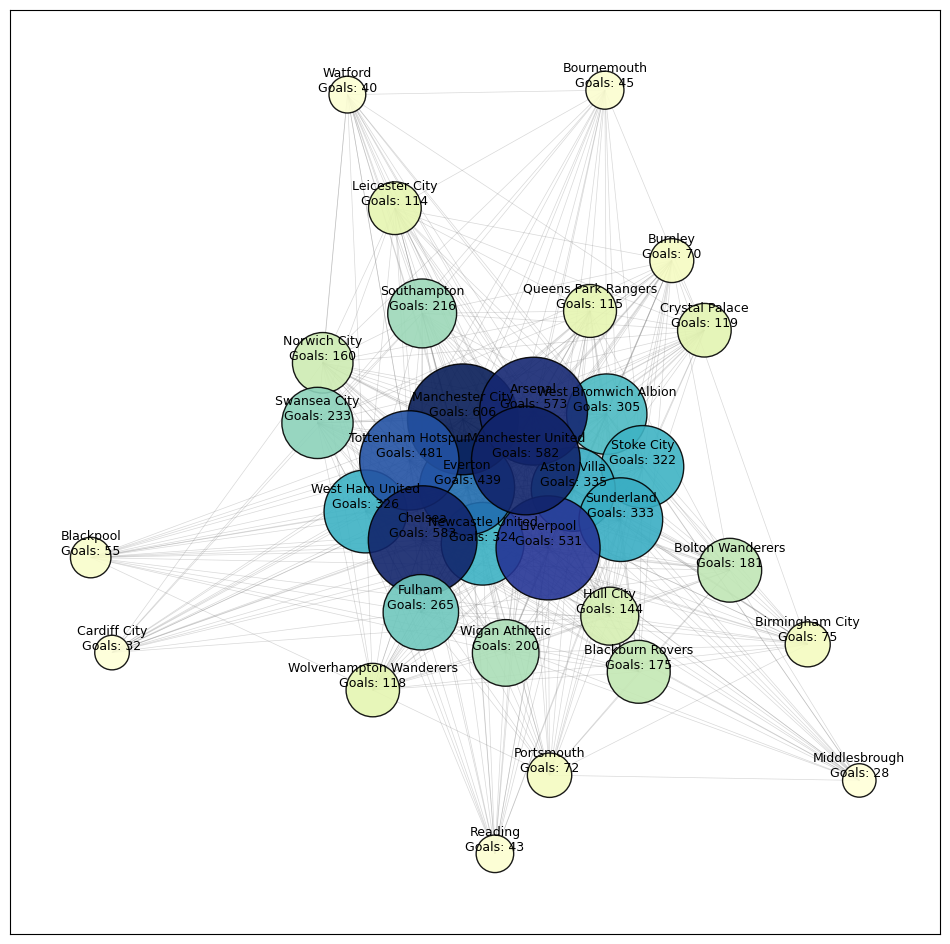

In [24]:
# Step 1: Create a subgraph for the England Premier League

# Draw nodes with sizes based on goals and a color gradient
import matplotlib.colors as mcolors
# Identify teams in the England Premier League
epl_teams = [node for node, data in G.nodes(data=True) if data.get('league') == 'England Premier League']

# Create a subgraph containing only England Premier League teams
G_epl = G.subgraph(epl_teams).copy()

# Step 2: Prepare node sizes and labels based on total goals scored

# Define node sizes and labels
node_sizes_goals = []
node_labels = {}
for node in G_epl.nodes():
    total_goals = G_epl.nodes[node].get('total_goals_scored', 0)
    # Set a minimum node size for visibility
    node_size = 300 + (total_goals * 10)
    node_sizes_goals.append(node_size)
    # Create labels with team name and total goals
    node_labels[node] = f"{node}\nGoals: {total_goals}"

# Normalize node sizes for visualization (optional, if needed)
# max_goals = max(node_sizes_goals) if node_sizes_goals else 1
# node_sizes_goals = [500 * (size / max_goals) for size in node_sizes_goals]

# Step 3: Improve edge appearance

# Set edge widths based on the number of matches between teams
# If edge data includes weights (e.g., number of matches), you can use it
edge_widths = []
for u, v in G_epl.edges():
    edge_widths.append(1)  # Set a constant width or adjust based on edge attributes

# Step 4: Draw the enhanced network visualization



# Set the figure size
plt.figure(figsize=(12, 12))

# Use a layout that improves readability
pos = nx.spring_layout(G_epl, k=0.8, iterations=50, seed=42)

# Draw edges with reduced opacity and thinner lines
nx.draw_networkx_edges(
    G_epl,
    pos,
    width=0.5,  # Thinner edges
    alpha=0.3,   # More transparent edges
    edge_color='gray'
)


# Create a color map based on total goals scored
total_goals_list = [G_epl.nodes[node].get('total_goals_scored', 0) for node in G_epl.nodes()]
cmap = plt.cm.YlGnBu  # You can choose any matplotlib colormap
norm = plt.Normalize(vmin=min(total_goals_list), vmax=max(total_goals_list))
node_colors = [cmap(norm(G_epl.nodes[node].get('total_goals_scored', 0))) for node in G_epl.nodes()]

nx.draw_networkx_nodes(
    G_epl,
    pos,
    node_size=node_sizes_goals,
    node_color=node_colors,
    cmap=cmap,
    alpha=0.9,
    linewidths=1,
    edgecolors='black'
)

# Add labels with team names and total goals
nx.draw_networkx_labels(
    G_epl,
    pos,
    labels=node_labels,
    font_size=9,
    font_family='sans-serif',
    verticalalignment='bottom'
)

# Create a colorbar for the nodes
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.7)
cbar.set_label('Total Goals Scored')

# Set plot title and remove axes
plt.title('England Premier League Teams: Node Size and Color Proportional to Total Goals Scored', fontsize=14)
plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
